<a href="https://colab.research.google.com/github/hf2000510/twitter_poll/blob/master/twitter_pol_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [**Click here to view the notebook (GitHub does not show the graphics!)**](https://colab.research.google.com/github/hf2000510/twitter_poll/blob/master/twitter_pol_notebook.ipynb)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

### **_This notebook explains and showcases the main parts of the project - the "clean" and ready-to-use code is in separate python files that are explained/documented in the readme file_**


## Predicting political affiliation from Tweets

The aim of this project is to train a neural network to predict a Twitter user's political affiliation from his or her tweets. The network showcased here achieves an accuracy of around 82-87%. Further applications of the developed network are:
* Classifying news articles by predicting the political affiliation of those who retweet and like them
* Looking at if/how "filter bubbles" develop by analyzing user's social graph through the network

#### (1. Getting the Tweets -- in tweets.py)
tweets.py gets tweets and stores them in the data directory. There is one text file per party. All words occuring at least 3 times over all tweets are then stored in the vocab.txt file
#### 2. Vocabulary and Bag-of-Words-Representation
The vocabulary is initialized from vocab.txt. Through all tweets stored in the data-directory, the first 10 lines (i.e. users) make up the validation set,
the next 50 lines make up the training set and the rest is for testing.


In [75]:
import numpy
import matplotlib.pyplot
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()
from keras.layers import Dense, Dropout, ActivityRegularization
from keras.preprocessing.text import Tokenizer
from keras.engine.sequential import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import regularizers
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure


In [0]:
with open("/content/gdrive/My Drive/twitter_pol/data/vocab.txt", 'r') as vocab_file:
    vocab_file = vocab_file.readlines()
    vocab = [word.strip() for word in vocab_file]
    vocab = set(vocab)


def getlines(filename):
    with open(filename, 'r') as f:
        f.readline()
        f = f.readlines()
        li = list()
        for index, line in enumerate(f):
            if index < 10:
                continue
            if index == 60:
                break
            tokens = line.strip().split()
            tokens = [w for w in tokens if w in vocab]
            li.append(' '.join(tokens))
    return li


def getlines_validation(filename):
    with open(filename, 'r') as f:
        f.readline()
        f = f.readlines()
        li = list()
        for index, line in enumerate(f):
            if index==10:
                break
            tokens = line.strip().split()
            tokens = [w for w in tokens if w in vocab]
            li.append(' '.join(tokens))
    return li

def getlines_test(filename):
    with open(filename, 'r') as f:
        f.readline()
        f = f.readlines()
        li = list()
        for index, line in enumerate(f):
            if index < 60:
                continue
            tokens = line.strip().split()
            tokens = [w for w in tokens if w in vocab]
            li.append(' '.join(tokens))
    return li



# Training data
afd_lines = getlines("/content/gdrive/My Drive/twitter_pol/data/tweets/afd_tokens.txt")
cdu_lines = getlines("/content/gdrive/My Drive/twitter_pol/data/tweets/cdu_tokens.txt")
fdp_lines = getlines("/content/gdrive/My Drive/twitter_pol/data/tweets/fdp_tokens.txt")
greens_lines = getlines("/content/gdrive/My Drive/twitter_pol/data/tweets/greens_tokens.txt")
linke_lines = getlines("/content/gdrive/My Drive/twitter_pol/data/tweets/linke_tokens.txt")
spd_lines = getlines("/content/gdrive/My Drive/twitter_pol/data/tweets/spd_tokens.txt")

tokenizer = Tokenizer()
all_lines = afd_lines + cdu_lines + fdp_lines + greens_lines + linke_lines + spd_lines

tokenizer.fit_on_texts(all_lines)

# Validation data
afd_lines_validation = getlines_validation("/content/gdrive/My Drive/twitter_pol/data/tweets/afd_tokens.txt")
cdu_lines_validation = getlines_validation("/content/gdrive/My Drive/twitter_pol/data/tweets/cdu_tokens.txt")
fdp_lines_validation = getlines_validation("/content/gdrive/My Drive/twitter_pol/data/tweets/fdp_tokens.txt")
greens_lines_validation = getlines_validation("/content/gdrive/My Drive/twitter_pol/data/tweets/greens_tokens.txt")
linke_lines_validation = getlines_validation("/content/gdrive/My Drive/twitter_pol/data/tweets/linke_tokens.txt")
spd_lines_validation = getlines_validation("/content/gdrive/My Drive/twitter_pol/data/tweets/spd_tokens.txt")

all_lines_validation = afd_lines_validation + cdu_lines_validation + fdp_lines_validation + greens_lines_validation + linke_lines_validation + spd_lines_validation


# Test data
afd_lines_test = getlines_test("/content/gdrive/My Drive/twitter_pol/data/tweets/afd_tokens.txt")
cdu_lines_test = getlines_test("/content/gdrive/My Drive/twitter_pol/data/tweets/cdu_tokens.txt")
fdp_lines_test = getlines_test("/content/gdrive/My Drive/twitter_pol/data/tweets/fdp_tokens.txt")
greens_lines_test = getlines_test("/content/gdrive/My Drive/twitter_pol/data/tweets/greens_tokens.txt")
linke_lines_test = getlines_test("/content/gdrive/My Drive/twitter_pol/data/tweets/linke_tokens.txt")
spd_lines_test = getlines_test("/content/gdrive/My Drive/twitter_pol/data/tweets/spd_tokens.txt")

all_lines_test = afd_lines_test + cdu_lines_test + fdp_lines_test + greens_lines_test + linke_lines_test + spd_lines_test





#### 3. Creating/Training/Testing the Neural Network
Using keras, a neural network with one hidden layer is set up. Encoding mode, number of hidden nodes, dropout rate, learning rate and number of epochs can be changed. As we are trying to classify tweets into one of six parties, we are using categorical crossentropy as loss function. The data is shuffled.  

In [0]:
def model(encoding_mode, hidden_nodes, dropout_rate, learning_rate, epochs):
    
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(all_lines, mode=encoding_mode)
      
    # encode validation data set
    Xvalidate = tokenizer.texts_to_matrix(all_lines_validation, mode=encoding_mode)

    # encode testing data set
    Xtest = tokenizer.texts_to_matrix(all_lines_test, mode=encoding_mode)


    
    n_words = Xtest.shape[1]  # input size
    
    ytrain = numpy.array([0 for _ in range(50)] + [1 for _ in range(50)] + [2 for _ in range(50)] +
                         [3 for _ in range(50)] + [4 for _ in range(50)] + [5 for _ in range(50)])
    ytrain = to_categorical(ytrain)
    
    yvalidate = numpy.array([0 for _ in range(10)] + [1 for _ in range(10)] + [2 for _ in range(10)] +
                         [3 for _ in range(10)] + [4 for _ in range(10)] + [5 for _ in range(10)])
    yvalidate = to_categorical(yvalidate)

    ytest = numpy.array([0 for _ in range(19)] + [1 for _ in range(22)] + [2 for _ in range(18)] +
                        [3 for _ in range(14)] + [4 for _ in range(3)] + [5 for _ in range(31)])
    ytest = to_categorical(ytest)
    
    model = Sequential()
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_nodes, input_shape=(n_words,), activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(6, activation='softmax'))
    
    opt = SGD(lr=learning_rate, decay=0.000009, momentum=0.9)
    model.compile(loss='categorical_crossentropy', optimizer=opt, shuffle=True, metrics=['accuracy'])
    
    history = model.fit(Xtrain, ytrain, validation_data=(Xvalidate, yvalidate), epochs=epochs, verbose=0)    

    # Visualisation
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    figure(figsize=(20,4))
    matplotlib.pyplot.plot(epochs, loss, 'g', label='Training loss')
    matplotlib.pyplot.plot(epochs, val_loss, 'b', label='Validation loss')
    matplotlib.pyplot.title('Training and validation loss')
    matplotlib.pyplot.xlabel('Epochs')
    matplotlib.pyplot.ylabel('Loss')
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    figure(figsize=(20,4))
    matplotlib.pyplot.plot(epochs, acc, 'g', label='Training acc')
    matplotlib.pyplot.plot(epochs, val_acc, 'b', label='Validation acc')
    matplotlib.pyplot.title('Training and validation accuracy')
    matplotlib.pyplot.xlabel('Epochs')
    matplotlib.pyplot.ylabel('Accuracy')
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()
    test_loss, test_acc = model.evaluate(Xtest, ytest)
    print(test_acc)


    # store performance of model (and the model's parameters)
    with open('/content/gdrive/My Drive/twitter_pol/data/performance.txt', 'a') as f:
        str_out = "encoding mode: " + str(encoding_mode) + " hidden nodes: " + str(hidden_nodes) + \
                " dropout rate: " + str(dropout_rate) + " learning rate: " + str(learning_rate) + \
                " epochs: " + str(epochs) + " Test: " + str(test_acc) + "\n"
        f.write(str_out)
    print(str_out)

    return model


#### 4. Finding suited parameters
Out of all encoding options (binary/count/tf-inverse-df/freq), frequency encoding has proven to be most useful for this application. 5000 nodes in the hidden layer and a dropout probability of 50% work best. Learning rates close to 0.01 showed too much oscillation throughout. Lowering to 0.005, 0.00375 and finally ending up at 0.00425 resulted in a more robust network (4 examples shown below; they only differ in learning rate). The fourth example shows good hyper-parameters to be frequency encoding/5000 neurons in hidden layer/learning rate 0.00425/~3000 epochs. 

Accuracy hovers around 82-87%.

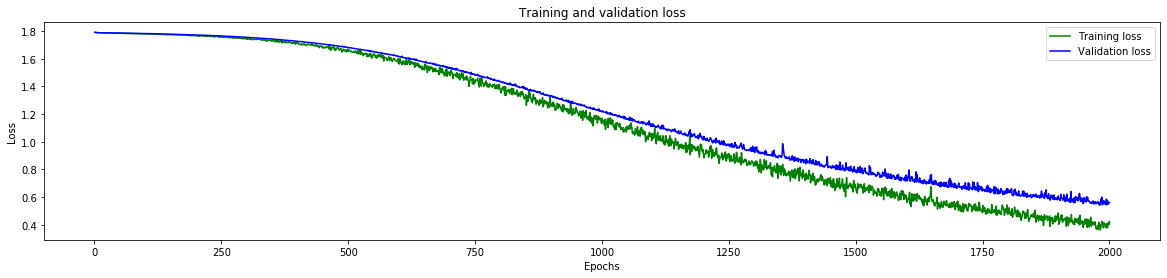

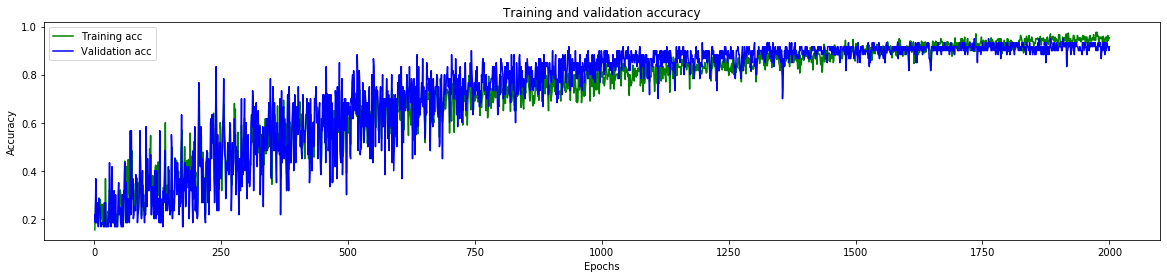

107/107 [==============================] - 0s 145us/step
0.8411214981123666
encoding mode: freq hidden nodes: 5000 dropout rate: 0.5 learning rate: 0.009 epochs: range(1, 2001) Test: 0.8411214981123666



In [0]:
model('freq', 5000, 0.5, 0.009, 2000)

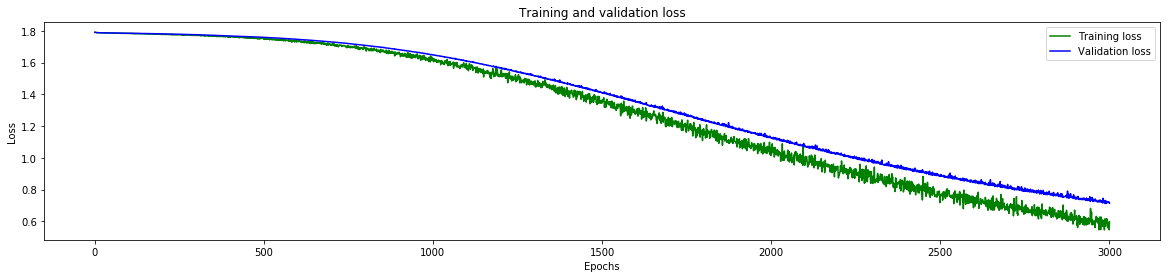

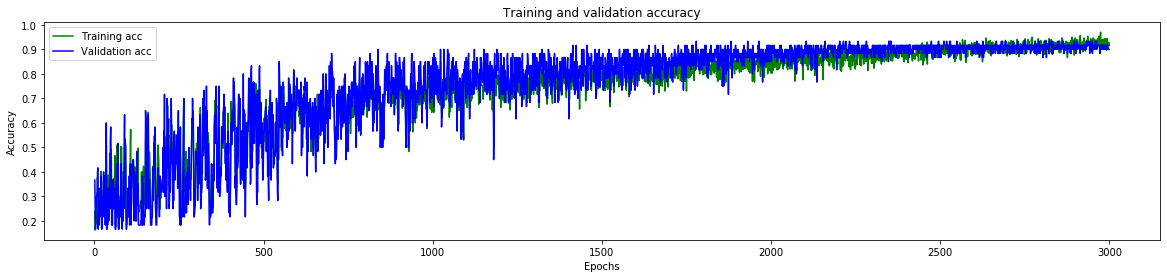

107/107 [==============================] - 0s 127us/step
0.8598130868974133
encoding mode: freq hidden nodes: 5000 dropout rate: 0.5 learning rate: 0.005 epochs: range(1, 3001) Test: 0.8598130868974133



In [0]:
model('freq', 5000, 0.5, 0.005, 3000)

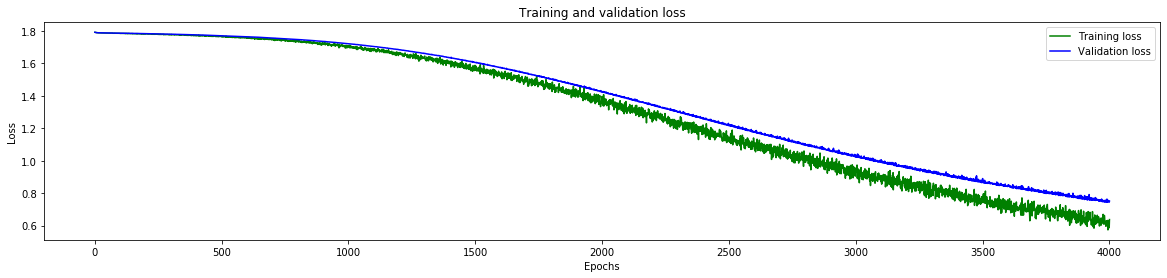

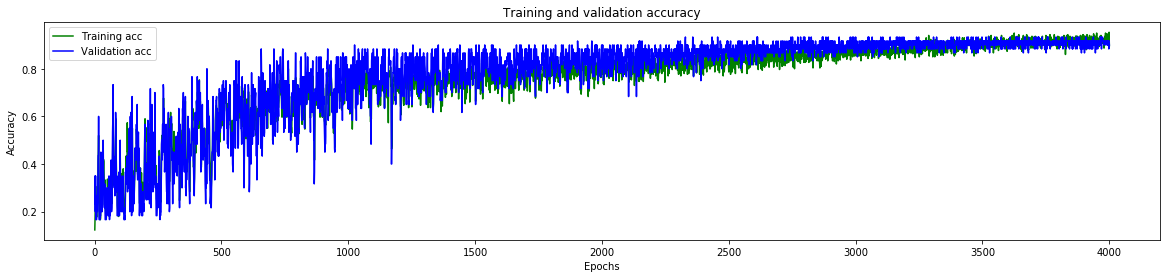

107/107 [==============================] - 0s 146us/step
0.8411214981123666
encoding mode: freq hidden nodes: 5000 dropout rate: 0.5 learning rate: 0.00375 epochs: range(1, 4001) Test: 0.8411214981123666



In [0]:
model('freq', 5000, 0.5, 0.00375, 4000)

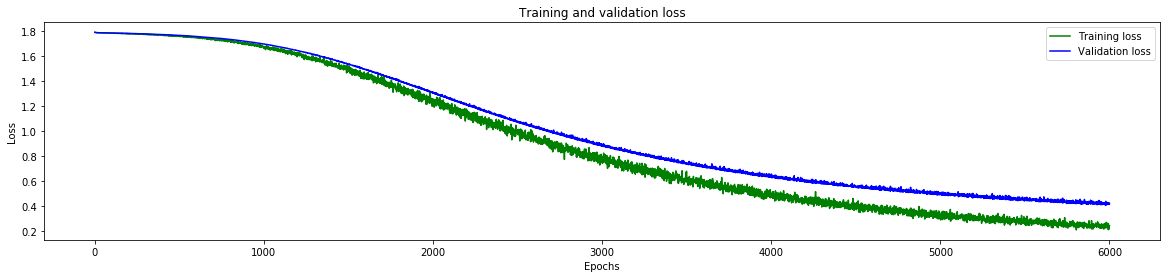

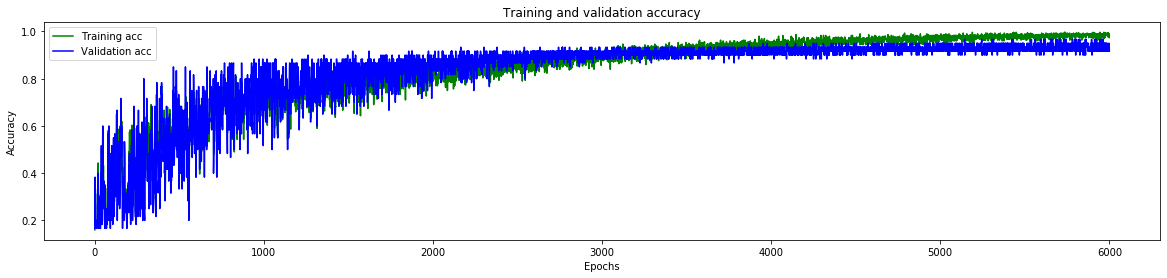

107/107 [==============================] - 0s 181us/step
0.8878504700749834
encoding mode: freq hidden nodes: 5000 dropout rate: 0.5 learning rate: 0.00425 epochs: range(1, 6001) Test: 0.8878504700749834



In [0]:
model('freq', 5000, 0.5, 0.00425, 6000)

### 5. Using the Neural Network
Define one model with the chosen parameters to work with.

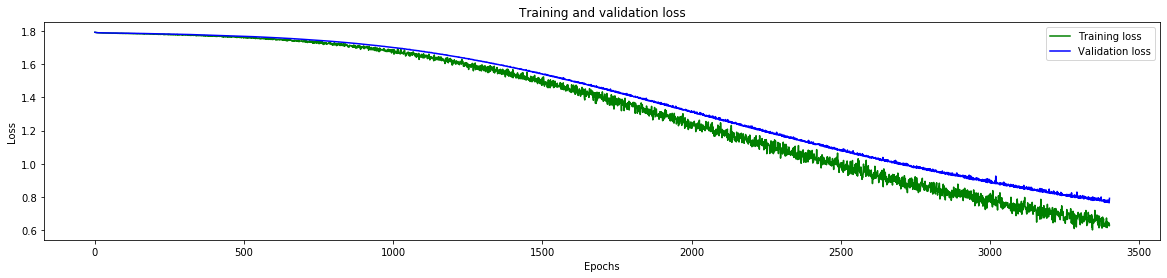

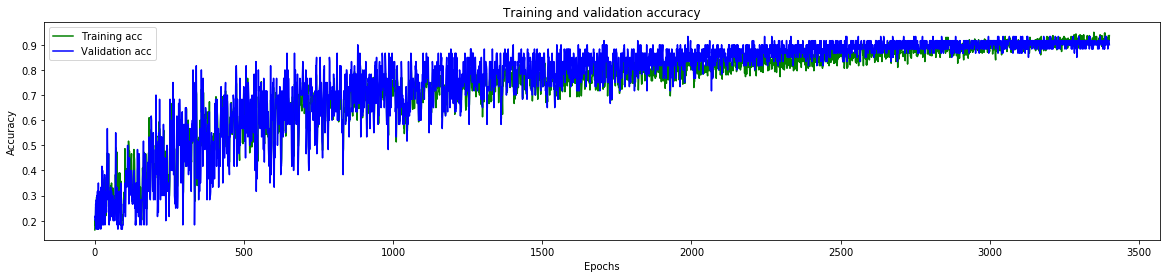

107/107 [==============================] - 0s 334us/step
0.822429906542056
encoding mode: freq hidden nodes: 5000 dropout rate: 0.5 learning rate: 0.00425 epochs: range(1, 3401) Test: 0.822429906542056



In [97]:
mymodel = model('freq', 5000, 0.5, 0.00425, 3400)

### Functions to use the network with one twitter username
1. Load module "tweets" - that's where the function "tweets.singlesearch" to get tweets from a user is defined.
2. Function "query_user": takes a twitter username, a Neural Network, a vocabulatory, and a tokenizer. Returns the Neural Network's output for the user's last 100 tweets.
3. Function "predict_party": Takes the prediction of query_user's return tuple. Returns the prediction as integer from 0 to 6 with encoding 0->AfD, 1->CDU, 2->FDP, 3->Greens, 4->Linke, 5->SPD
4. Function "plot_prediction": Takes query_user's return tuple. Plots the network's prediction.

In [0]:
!pip install TwitterSearch

import nltk
nltk.download('stopwords')
import importlib.util


spec = importlib.util.spec_from_file_location("tweets", "/content/gdrive/My Drive/twitter_pol/tweets.py")
tweets = importlib.util.module_from_spec(spec)
spec.loader.exec_module(tweets)

In [0]:
def query_user(twitter_username, model, vocab, tokenizer):
  user_tokens = tweets.singlesearch(twitter_username)
  user_tokens = [token for token in user_tokens if token in vocab]
  user_tokens = ' '.join(user_tokens)
  encoded_tokens = tokenizer.texts_to_matrix([user_tokens], mode='freq')
  prediction = model.predict(encoded_tokens, verbose=0)
  return (prediction, twitter_username)


In [0]:
def predict_party(user_prediction):
  return numpy.argmax(numpy.squeeze(user_prediction))

In [0]:
def plot_prediction(user_prediction, username):
  fig, ax = plt.subplots()
  rects1 = ax.bar(np.arange(len(numpy.squeeze(user_prediction))),numpy.squeeze(user_prediction))
  ax.set_xticks(np.arange(len(numpy.squeeze(user_prediction))))
  ax.set_xticklabels(('AfD', 'CDU', 'FDP', 'Greens', 'Linke', 'SPD'))
  ax.set_ylabel('Confidence')
  ax.set_xlabel('Party')
  ax.yaxis.set_label_coords(-0.12,0.5)
  title = "username: " + username
  ax.set_title(title)
  matplotlib.pyplot.show()


### Showcasing the network:
Of course, none of the accounts shown here were present in training/validation/test data.


"AfD_HD" is the official twitter account of the AfD in Heidelberg.

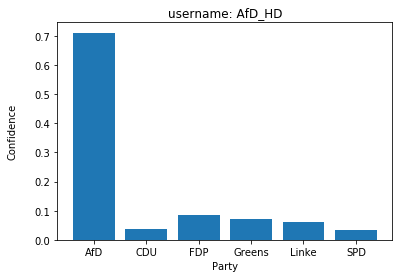

Prediction integer: 0


In [187]:
test_prediction, test_username  = query_user('AfD_HD', mymodel, vocab, tokenizer) 
plot_prediction(test_prediction, test_username)
print("Prediction integer:", predict_party(test_prediction))

Malte Kaufmann is chairman of the AfD Heidelberg

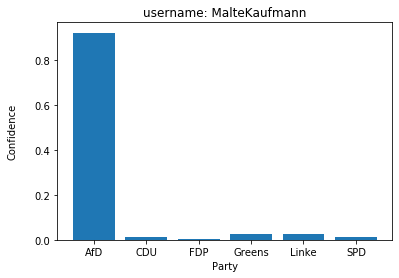

Prediction integer: 0


In [188]:
test_prediction, test_username  = query_user('MalteKaufmann', mymodel, vocab, tokenizer) 
plot_prediction(test_prediction, test_username)
print("Prediction integer:", predict_party(test_prediction))

Official twitter account of CDU in Saxony

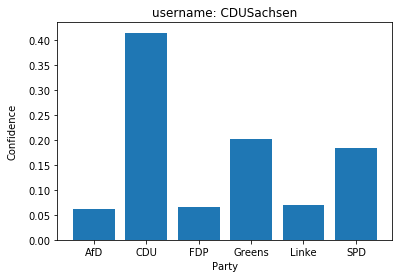

Prediction integer: 1


In [190]:
test_prediction, test_username  = query_user('CDUSachsen', mymodel, vocab, tokenizer) 
plot_prediction(test_prediction, test_username)
print("Prediction integer:", predict_party(test_prediction))

Official account of SPD in Hamburg

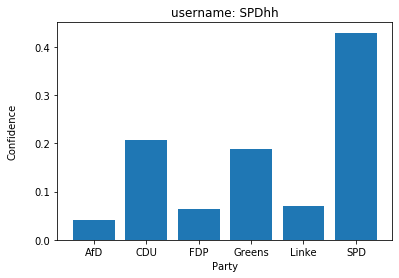

Prediction integer: 5


In [192]:
test_prediction, test_username  = query_user('SPDhh', mymodel, vocab, tokenizer) 
plot_prediction(test_prediction, test_username)
print("Prediction integer:", predict_party(test_prediction))

Official account of Green Party


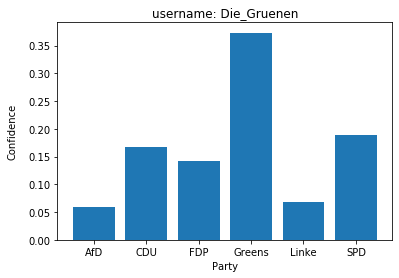

Prediction integer: 3


In [196]:
test_prediction, test_username  = query_user('Die_Gruenen', mymodel, vocab, tokenizer) 
plot_prediction(test_prediction, test_username)
print("Prediction integer:", predict_party(test_prediction))

Official account of Linke in the national parliament

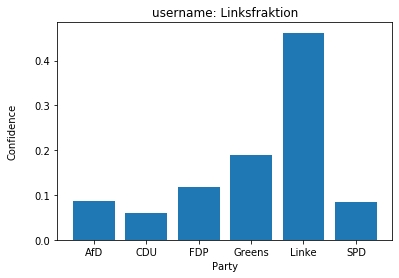

Prediction integer: 4


In [194]:
test_prediction, test_username  = query_user('Linksfraktion', mymodel, vocab, tokenizer) 
plot_prediction(test_prediction, test_username)
print("Prediction integer:", predict_party(test_prediction))

Official account of FDP in the national parliament

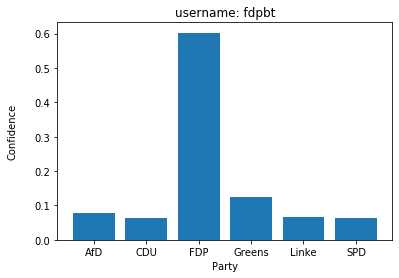

Prediction integer: 2


In [195]:
test_prediction, test_username  = query_user('fdpbt', mymodel, vocab, tokenizer) 
plot_prediction(test_prediction, test_username)
print("Prediction integer:", predict_party(test_prediction))